In [ ]:
# Install necessary packages
!pip install kaggle torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Set your Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'engr_ikhlaq'
os.environ['KAGGLE_KEY'] = 'your_kaggle_api_key'

# Download CelebA dataset from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

# Create a directory to unzip the dataset
!mkdir -p /content/celeba

# Unzip the dataset into the created directory
!unzip -q -o celeba-dataset.zip -d /content/celeba

# Path to the dataset
file_location = "/content/celeba"


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:11<00:00, 42.3MB/s]
100% 1.33G/1.33G [00:11<00:00, 121MB/s] 


In [ ]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 128
image_size = 64
channel_img = 3
z_dim = 100
num_epochs = 25
feature_d = 64
feature_g = 64
critic_iterations = 5
lambda_GP = 10
num_workers = 4  # Number of workers for data loading

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * channel_img, [0.5] * channel_img)
])

# Create the dataset and DataLoader
dataset = datasets.ImageFolder(root=file_location, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)


In [ ]:
# Define Critic (Discriminator) class
class Critic(nn.Module):
    def __init__(self, channel_img, feature_d):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(feature_d, feature_d * 2, 4, 2, 1),
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),
            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.disc(x)

# Define Generator class
class Generator(nn.Module):
    def __init__(self, z_dim, channel_img, feature_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, feature_g * 16, 4, 1, 0),
            self._block(feature_g * 16, feature_g * 8, 4, 2, 1),
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(feature_g * 2, channel_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.gen(x)

# Function to initialize model weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

# Function to calculate gradient penalty
def gradient_penalty(critic, real, fake, device='cpu'):
    batch_size, C, H, W = real.shape
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

# Create instances of Critic and Generator
critic = Critic(channel_img, feature_d).to(device)
gen = Generator(z_dim, channel_img, feature_g).to(device)

# Initialize weights of Critic and Generator
initialize_weights(critic)
initialize_weights(gen)

# Define optimizers
opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.0, 0.9))

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/25] Batch [0/1582] LossD: 611.5762, LossG: -0.2220
Epoch [0/25] Batch [100/1582] LossD: -118.6692, LossG: 125.2233
Epoch [0/25] Batch [200/1582] LossD: -86.4363, LossG: 128.0274
Epoch [0/25] Batch [300/1582] LossD: -51.4490, LossG: 124.3326
Epoch [0/25] Batch [400/1582] LossD: -36.5889, LossG: 124.7957
Epoch [0/25] Batch [500/1582] LossD: -26.9821, LossG: 113.8903
Epoch [0/25] Batch [600/1582] LossD: -23.3673, LossG: 111.2403
Epoch [0/25] Batch [700/1582] LossD: -18.7578, LossG: 106.6445
Epoch [0/25] Batch [800/1582] LossD: -16.3894, LossG: 94.9658
Epoch [0/25] Batch [900/1582] LossD: -20.3392, LossG: 89.6882
Epoch [0/25] Batch [1000/1582] LossD: -18.0795, LossG: 86.9405
Epoch [0/25] Batch [1100/1582] LossD: -16.8599, LossG: 91.3013
Epoch [0/25] Batch [1200/1582] LossD: -18.1371, LossG: 90.1629
Epoch [0/25] Batch [1300/1582] LossD: -19.7316, LossG: 84.7538
Epoch [0/25] Batch [1400/1582] LossD: -15.8545, LossG: 85.7139
Epoch [0/25] Batch [1500/1582] LossD: -13.8480, LossG: 78.0

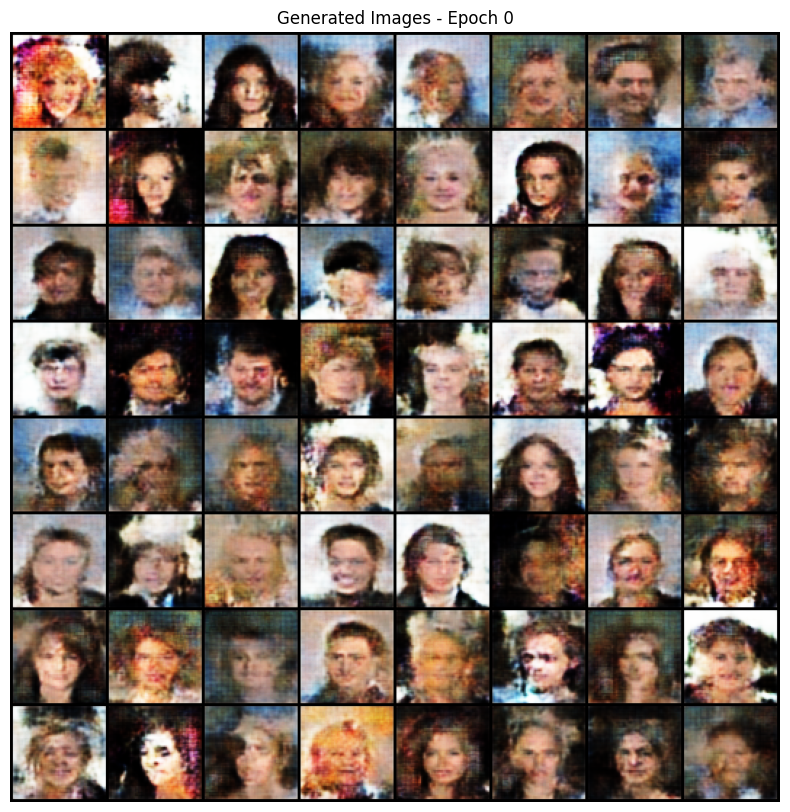

Epoch [1/25] Batch [0/1582] LossD: -14.3284, LossG: 84.8057
Epoch [1/25] Batch [100/1582] LossD: -14.1763, LossG: 83.8052
Epoch [1/25] Batch [200/1582] LossD: -13.8981, LossG: 80.0543
Epoch [1/25] Batch [300/1582] LossD: -14.2652, LossG: 88.1642
Epoch [1/25] Batch [400/1582] LossD: -13.2933, LossG: 76.2840
Epoch [1/25] Batch [500/1582] LossD: -14.8909, LossG: 81.7846
Epoch [1/25] Batch [600/1582] LossD: -13.5446, LossG: 82.4081
Epoch [1/25] Batch [700/1582] LossD: -12.2741, LossG: 79.0383
Epoch [1/25] Batch [800/1582] LossD: -13.1302, LossG: 77.1646
Epoch [1/25] Batch [900/1582] LossD: -12.2566, LossG: 77.0299
Epoch [1/25] Batch [1000/1582] LossD: -12.2512, LossG: 82.8181
Epoch [1/25] Batch [1100/1582] LossD: -10.6523, LossG: 85.9710
Epoch [1/25] Batch [1200/1582] LossD: -13.4823, LossG: 84.2325
Epoch [1/25] Batch [1300/1582] LossD: -9.7829, LossG: 83.0488
Epoch [1/25] Batch [1400/1582] LossD: -11.1454, LossG: 85.7962
Epoch [1/25] Batch [1500/1582] LossD: -9.0718, LossG: 72.3053


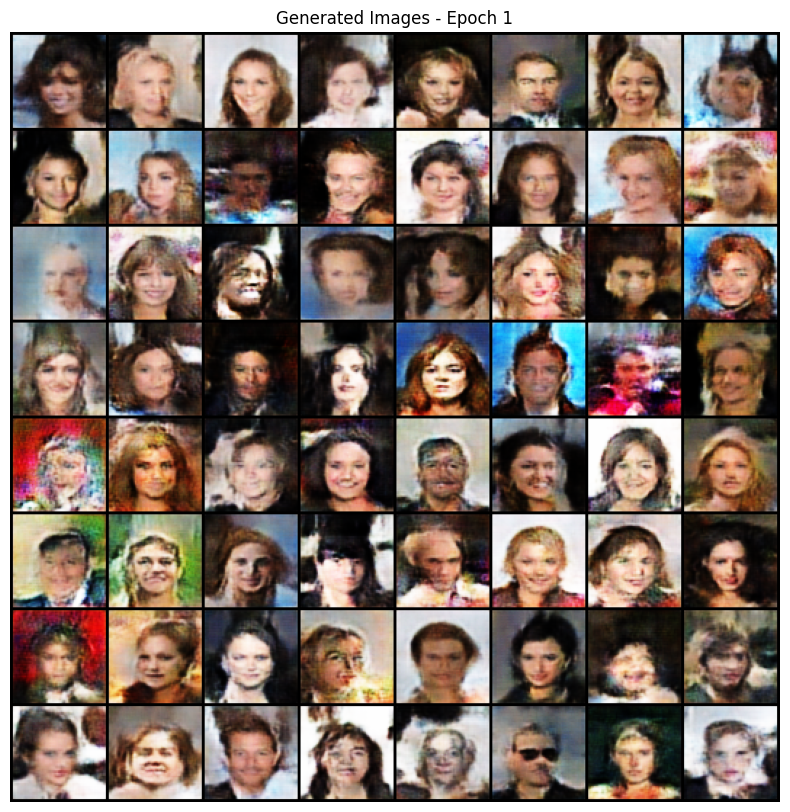

Epoch [2/25] Batch [0/1582] LossD: -10.3324, LossG: 73.4427
Epoch [2/25] Batch [100/1582] LossD: -8.0206, LossG: 76.8013
Epoch [2/25] Batch [200/1582] LossD: -10.5629, LossG: 75.9284
Epoch [2/25] Batch [300/1582] LossD: -9.9795, LossG: 72.0518
Epoch [2/25] Batch [400/1582] LossD: -10.0121, LossG: 76.2612
Epoch [2/25] Batch [500/1582] LossD: -9.5450, LossG: 78.4317
Epoch [2/25] Batch [600/1582] LossD: -9.9065, LossG: 79.4756
Epoch [2/25] Batch [700/1582] LossD: -10.3002, LossG: 78.2786
Epoch [2/25] Batch [800/1582] LossD: -9.6257, LossG: 79.8026
Epoch [2/25] Batch [900/1582] LossD: -9.7290, LossG: 71.7594
Epoch [2/25] Batch [1000/1582] LossD: -9.7339, LossG: 76.7044
Epoch [2/25] Batch [1100/1582] LossD: -9.1603, LossG: 76.4776
Epoch [2/25] Batch [1200/1582] LossD: -8.0660, LossG: 78.7204
Epoch [2/25] Batch [1300/1582] LossD: -10.7654, LossG: 78.2216
Epoch [2/25] Batch [1400/1582] LossD: -9.5656, LossG: 83.6420
Epoch [2/25] Batch [1500/1582] LossD: -10.0509, LossG: 74.9639


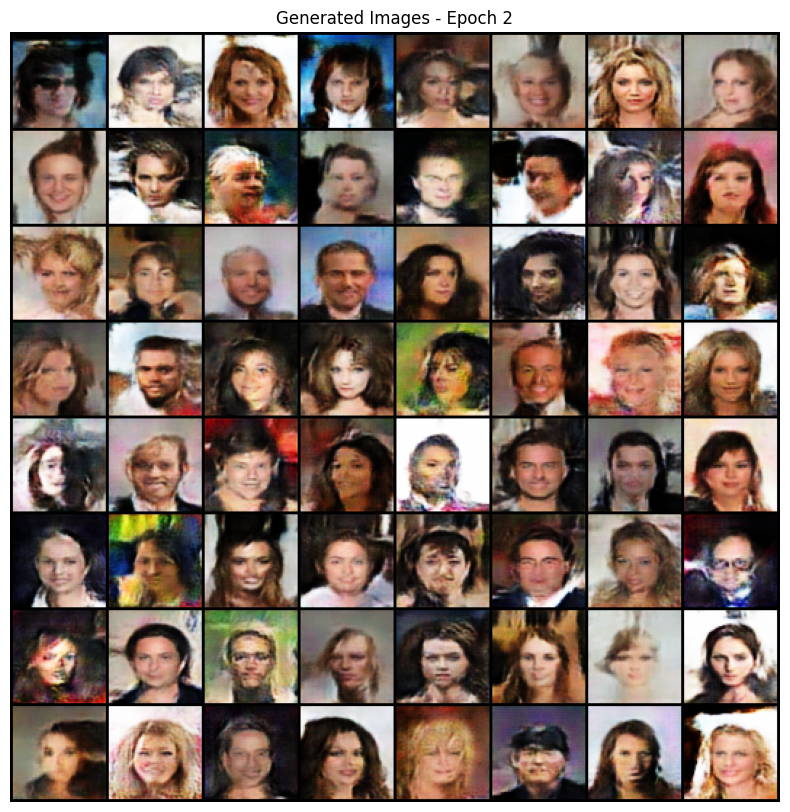

Epoch [3/25] Batch [0/1582] LossD: -8.0520, LossG: 87.7990
Epoch [3/25] Batch [100/1582] LossD: -8.7370, LossG: 75.5377
Epoch [3/25] Batch [200/1582] LossD: -10.3034, LossG: 75.6798
Epoch [3/25] Batch [300/1582] LossD: -9.0270, LossG: 74.8528
Epoch [3/25] Batch [400/1582] LossD: -9.7291, LossG: 87.6423
Epoch [3/25] Batch [500/1582] LossD: -8.6319, LossG: 75.3394
Epoch [3/25] Batch [600/1582] LossD: -9.2967, LossG: 70.0348
Epoch [3/25] Batch [700/1582] LossD: -10.8820, LossG: 78.2774
Epoch [3/25] Batch [800/1582] LossD: -6.9886, LossG: 74.9757
Epoch [3/25] Batch [900/1582] LossD: -8.7001, LossG: 70.3156
Epoch [3/25] Batch [1000/1582] LossD: -7.9104, LossG: 76.7166
Epoch [3/25] Batch [1100/1582] LossD: -8.4938, LossG: 78.8113
Epoch [3/25] Batch [1200/1582] LossD: -14.0143, LossG: 56.5664
Epoch [3/25] Batch [1300/1582] LossD: -7.9040, LossG: 83.1698
Epoch [3/25] Batch [1400/1582] LossD: -7.8620, LossG: 83.8540
Epoch [3/25] Batch [1500/1582] LossD: -8.0274, LossG: 82.1840


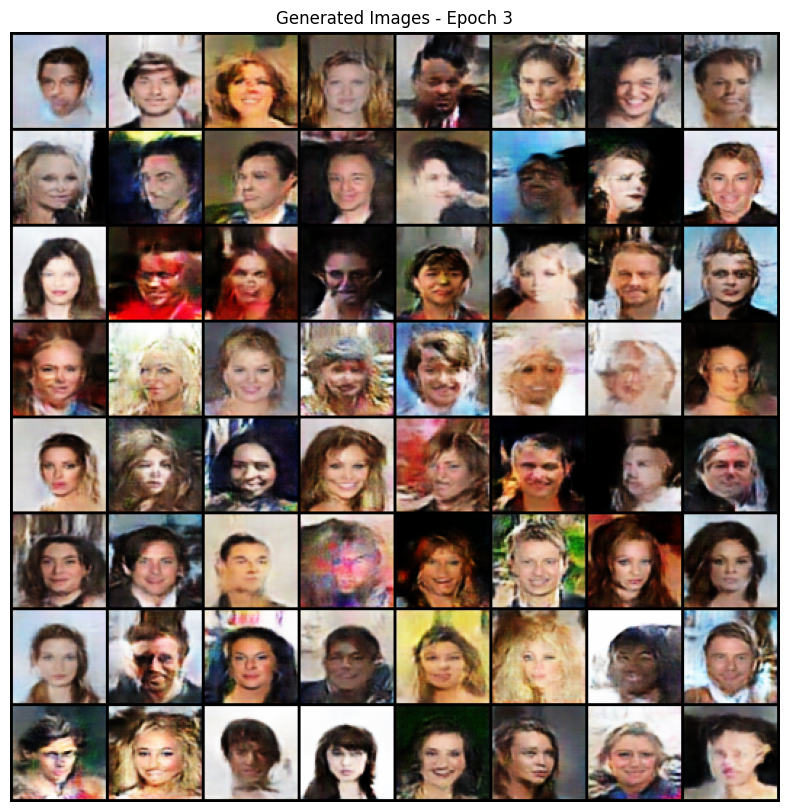

Epoch [4/25] Batch [0/1582] LossD: -8.2643, LossG: 71.4883
Epoch [4/25] Batch [100/1582] LossD: -7.5967, LossG: 78.9189
Epoch [4/25] Batch [200/1582] LossD: -11.0619, LossG: 74.2646


In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Define the training function
def train(num_epochs, loader, critic, gen, opt_critic, opt_gen, device, z_dim):
    critic.train()
    gen.train()

    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(loader):
            real = real.to(device)
            batch_size = real.shape[0]

            for _ in range(critic_iterations):
                noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
                fake = gen(noise)
                critic_real = critic(real).reshape(-1)
                critic_fake = critic(fake.detach()).reshape(-1)
                gp = gradient_penalty(critic, real, fake, device=device)
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_GP * gp

                critic.zero_grad()
                scaler.scale(loss_critic).backward()
                scaler.step(opt_critic)
                scaler.update()

            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            output = critic(fake).reshape(-1)
            loss_gen = -torch.mean(output)

            gen.zero_grad()
            scaler.scale(loss_gen).backward()
            scaler.step(opt_gen)
            scaler.update()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] "
                      f"LossD: {loss_critic:.4f}, LossG: {loss_gen:.4f}")

        # Generate and display images after each epoch
        with torch.no_grad():
            fake_images = generate_images(gen, num_images, z_dim, device)

        grid = vutils.make_grid(fake_images[:64], nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Generated Images - Epoch {epoch}')
        plt.show()

# Function to generate images
def generate_images(generator, num_images, z_dim, device):
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
    return fake_images

# Train the model
num_images = 64
train(num_epochs, loader, critic, gen, opt_critic, opt_gen, device, z_dim)
